<a href="https://colab.research.google.com/github/badrishb/Anomaly-detection/blob/main/3D_CNN_Segmented_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and preprocessing Data

In [1]:
# !pip install -q imageio
# !pip install -q opencv-python
# !pip install -q git+https://github.com/tensorflow/docs
import os
import pandas as pd
import numpy as np
import cv2
import keras

In [2]:
# UCF_ROOT = "/content/drive/My Drive/Dataset/tozip/"  

In [3]:
labels=['Crime','norm']

In [4]:
#mount saebasasuke
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
imagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.10,height_shift_range=0.10,rescale=1/255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,fill_mode='nearest')

In [5]:
# !pip install pyunpack
# !pip install patool
# !rm -rf "/content/Crime"
# !pip install unrar
!cp '/content/drive/My Drive/seg.rar' './'
!unrar x 'seg.rar'
# !unzip "/content/drive/My Drive/seg.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from seg.rar

Creating    Crime                                                     OK
Extracting  Crime/Burglary001_x264.mp4                                     0%  OK 
Extracting  Crime/Burglary002_x264.mp4                                     0%  OK 
Extracting  Crime/Burglary003_x264.mp4                                     0%  OK 
Extracting  Crime/Burglary004_x264.mp4                                     0%  OK 
Extracting  Crime/Burglary005_x264.mp4                                     0%  OK 
Extracting  Crime/Burglary006_x264.mp4                                     0%  1%  OK 
Extracting  Crime/Burglary007_x264.mp4                                     1%  OK 
Extracting  Crime/Burglary008_x264.mp4                                     1%  OK 
Extracting  Crime/Burglary009_x264.mp4                                     1%  O

In [6]:
# !rm -rf 'dataset'

In [7]:
!mkdir dataset
!mv './Crime' 'dataset'
!mv './norm' 'dataset'

In [8]:
len(os.listdir('/content/dataset/Crime'))

348

In [ ]:
# len(os.listdir('dataset/norm'))

In [ ]:
os.listdir('dataset')

['Crime', 'norm']

In [4]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      # print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<0 or frame_count<1):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D

from tensorflow.keras.applications import ResNet50
import keras
from keras import layers
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2


In [6]:
!pip install keras-video-generators

In [7]:
from keras_video import VideoFrameGenerator

# Number of Frames:5

In [ ]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 5
BS = 8# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 114, train count: 234
class norm, validation count: 223, train count: 455
Total data: 2 classes for 689 files for train


In [ ]:
# import keras_video.utils
# keras_video.utils.show_sample(train)

In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(128, (3,3), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  # model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  # model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(LSTM(256))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 337 files for validation
Total data: 2 classes for 0 files for test


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 5, 32)             289600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 626,818
Trainable params: 626,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#NB Frames=5,highly less complex model with many layers commented out,dataset<5 or frame_count<5
EPOCHS=10
callbacks = [
keras.callbacks.ReduceLROnPlateau(verbose=1),
keras.callbacks.ModelCheckpoint(
    'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    verbose=1),
]
history=model.fit(
train,
validation_data=valid,
verbose=1,
epochs=EPOCHS,
callbacks=callbacks
)

Epoch 1/10
 5/76 [>.............................] - ETA: 9:47 - loss: 0.6749 - acc: 0.7000

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


16/76 [=====>........................] - ETA: 9:00 - loss: 0.6967 - acc: 0.5906

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


44/76 [================>.............] - ETA: 5:01 - loss: 0.6848 - acc: 0.6200

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


50/76 [==================>...........] - ETA: 3:56 - loss: 0.6800 - acc: 0.6247

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


55/76 [====================>.........] - ETA: 3:28 - loss: 0.6732 - acc: 0.6376

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


59/76 [======================>.......] - ETA: 2:43 - loss: 0.6763 - acc: 0.6338

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6811 - acc: 0.6130
Epoch 00001: saving model to chkp/weights.01-0.68.hdf5
76/76 [==============================] - 1080s 14s/step - loss: 0.6811 - acc: 0.6130 - val_loss: 0.6779 - val_acc: 0.6149
Epoch 2/10
22/76 [=======>......................] - ETA: 37s - loss: 0.6628 - acc: 0.6534

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


34/76 [============>.................] - ETA: 28s - loss: 0.6791 - acc: 0.6089

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


39/76 [==============>...............] - ETA: 24s - loss: 0.6740 - acc: 0.6194

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted
Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


40/76 [==============>...............] - ETA: 25s - loss: 0.6723 - acc: 0.6234

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


53/76 [===================>..........] - ETA: 15s - loss: 0.6715 - acc: 0.6205

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6737 - acc: 0.6113
Epoch 00002: saving model to chkp/weights.02-0.66.hdf5
76/76 [==============================] - 55s 720ms/step - loss: 0.6737 - acc: 0.6113 - val_loss: 0.6648 - val_acc: 0.6216
Epoch 3/10
 3/76 [>.............................] - ETA: 28s - loss: 0.6790 - acc: 0.5833

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


28/76 [==========>...................] - ETA: 27s - loss: 0.6716 - acc: 0.6099

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


50/76 [==================>...........] - ETA: 15s - loss: 0.6591 - acc: 0.6357

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


60/76 [======================>.......] - ETA: 9s - loss: 0.6629 - acc: 0.6310 

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


64/76 [========================>.....] - ETA: 7s - loss: 0.6645 - acc: 0.6280

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


67/76 [=========================>....] - ETA: 5s - loss: 0.6648 - acc: 0.6271

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6699 - acc: 0.6146
Epoch 00003: saving model to chkp/weights.03-0.67.hdf5
76/76 [==============================] - 49s 650ms/step - loss: 0.6699 - acc: 0.6146 - val_loss: 0.6689 - val_acc: 0.6182
Epoch 4/10
13/76 [====>.........................] - ETA: 35s - loss: 0.6706 - acc: 0.6154

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


25/76 [========>.....................] - ETA: 30s - loss: 0.6634 - acc: 0.6382

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


38/76 [==============>...............] - ETA: 22s - loss: 0.6701 - acc: 0.6159

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


55/76 [====================>.........] - ETA: 12s - loss: 0.6685 - acc: 0.6178

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


70/76 [==========================>...] - ETA: 3s - loss: 0.6706 - acc: 0.6115

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


74/76 [============================>.] - ETA: 1s - loss: 0.6712 - acc: 0.6099

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6698 - acc: 0.6130
Epoch 00004: saving model to chkp/weights.04-0.66.hdf5
76/76 [==============================] - 50s 652ms/step - loss: 0.6698 - acc: 0.6130 - val_loss: 0.6641 - val_acc: 0.6216
Epoch 5/10
26/76 [=========>....................] - ETA: 28s - loss: 0.6674 - acc: 0.6154

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


30/76 [==========>...................] - ETA: 26s - loss: 0.6657 - acc: 0.6192

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


38/76 [==============>...............] - ETA: 22s - loss: 0.6590 - acc: 0.6325

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


40/76 [==============>...............] - ETA: 21s - loss: 0.6614 - acc: 0.6278

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


45/76 [================>.............] - ETA: 18s - loss: 0.6637 - acc: 0.6236

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


72/76 [===========================>..] - ETA: 2s - loss: 0.6682 - acc: 0.6147

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6695 - acc: 0.6113
Epoch 00005: saving model to chkp/weights.05-0.67.hdf5
76/76 [==============================] - 49s 645ms/step - loss: 0.6695 - acc: 0.6113 - val_loss: 0.6659 - val_acc: 0.6182
Epoch 6/10
12/76 [===>..........................] - ETA: 34s - loss: 0.6793 - acc: 0.5833

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


15/76 [====>.........................] - ETA: 35s - loss: 0.6747 - acc: 0.5966

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted
Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


16/76 [=====>........................] - ETA: 35s - loss: 0.6708 - acc: 0.6080

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


27/76 [=========>....................] - ETA: 29s - loss: 0.6654 - acc: 0.6226

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


61/76 [=======================>......] - ETA: 8s - loss: 0.6705 - acc: 0.6087

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6695 - acc: 0.6113
Epoch 00006: saving model to chkp/weights.06-0.67.hdf5
76/76 [==============================] - 49s 645ms/step - loss: 0.6695 - acc: 0.6113 - val_loss: 0.6671 - val_acc: 0.6149
Epoch 7/10
12/76 [===>..........................] - ETA: 34s - loss: 0.6547 - acc: 0.6458

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


37/76 [=============>................] - ETA: 22s - loss: 0.6433 - acc: 0.6610

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


51/76 [===================>..........] - ETA: 14s - loss: 0.6630 - acc: 0.6281

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


68/76 [=========================>....] - ETA: 4s - loss: 0.6656 - acc: 0.6211

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


69/76 [==========================>...] - ETA: 4s - loss: 0.6675 - acc: 0.6168

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


73/76 [===========================>..] - ETA: 1s - loss: 0.6697 - acc: 0.6114

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6690 - acc: 0.6130
Epoch 00007: saving model to chkp/weights.07-0.67.hdf5
76/76 [==============================] - 49s 641ms/step - loss: 0.6690 - acc: 0.6130 - val_loss: 0.6661 - val_acc: 0.6182
Epoch 8/10
15/76 [====>.........................] - ETA: 33s - loss: 0.6855 - acc: 0.5667

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


34/76 [============>.................] - ETA: 24s - loss: 0.6735 - acc: 0.6015

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


44/76 [================>.............] - ETA: 18s - loss: 0.6696 - acc: 0.6114

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


56/76 [=====================>........] - ETA: 11s - loss: 0.6689 - acc: 0.6135

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


60/76 [======================>.......] - ETA: 9s - loss: 0.6698 - acc: 0.6113 

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


63/76 [=======================>......] - ETA: 7s - loss: 0.6670 - acc: 0.6172

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6688 - acc: 0.6130
Epoch 00008: saving model to chkp/weights.08-0.67.hdf5
76/76 [==============================] - 49s 647ms/step - loss: 0.6688 - acc: 0.6130 - val_loss: 0.6665 - val_acc: 0.6149
Epoch 9/10
12/76 [===>..........................] - ETA: 34s - loss: 0.6419 - acc: 0.6667

Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


14/76 [====>.........................] - ETA: 34s - loss: 0.6323 - acc: 0.6847

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


33/76 [============>.................] - ETA: 25s - loss: 0.6487 - acc: 0.6527

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


37/76 [=============>................] - ETA: 23s - loss: 0.6490 - acc: 0.6519

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted


51/76 [===================>..........] - ETA: 14s - loss: 0.6650 - acc: 0.6213

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


71/76 [===========================>..] - ETA: 3s - loss: 0.6690 - acc: 0.6110

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6682 - acc: 0.6130
Epoch 00009: saving model to chkp/weights.09-0.67.hdf5
76/76 [==============================] - 50s 652ms/step - loss: 0.6682 - acc: 0.6130 - val_loss: 0.6661 - val_acc: 0.6182
Epoch 10/10
11/76 [===>..........................] - ETA: 35s - loss: 0.6459 - acc: 0.6705

Frame count is not OK for video /content/dataset/norm/Burglary048_x264.mp4, 0 total, 0 extracted


17/76 [=====>........................] - ETA: 33s - loss: 0.6590 - acc: 0.6370

Frame count is not OK for video /content/dataset/norm/Burglary098_x264.mp4, 2 total, 1 extracted


23/76 [========>.....................] - ETA: 31s - loss: 0.6562 - acc: 0.6429

Frame count is not OK for video /content/dataset/norm/Burglary003_x264.mp4, 4 total, 3 extracted


50/76 [==================>...........] - ETA: 15s - loss: 0.6821 - acc: 0.5793

Frame count is not OK for video /content/dataset/norm/Stealing042_x264.mp4, 0 total, 0 extracted


63/76 [=======================>......] - ETA: 7s - loss: 0.6750 - acc: 0.6020

Frame count is not OK for video /content/dataset/norm/Burglary068_x264.mp4, 4 total, 4 extracted
Frame count is not OK for video /content/dataset/norm/Stealing071_x264.mp4, 2 total, 1 extracted


76/76 [==============================] - ETA: 0s - loss: 0.6707 - acc: 0.6130
Epoch 00010: saving model to chkp/weights.10-0.67.hdf5
76/76 [==============================] - 49s 648ms/step - loss: 0.6707 - acc: 0.6130 - val_loss: 0.6654 - val_acc: 0.6182


In [ ]:
model.evaluate(valid)

37/37 [==============================] - 4s 96ms/step - loss: 0.6668 - acc: 0.6149


[0.6668440699577332, 0.6148648858070374]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

298

In [ ]:
#NB Frames=5,highly less complex model with many layers commented out,dataset<5 or frame_count<5
# batch_size=64
# y=model.predict(valid)
# y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:-2], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:-2], y_pred, target_names=target_names))
print(accuracy_score(temp[:-2],y_pred))

confusion Matrix
[[  0 114]
 [  0 182]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.00      0.00      0.00       114
        norm       0.61      1.00      0.76       182

    accuracy                           0.61       296
   macro avg       0.31      0.50      0.38       296
weighted avg       0.38      0.61      0.47       296

0.6148648648648649


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Number of Frames:20

In [8]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      # print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<10 or frame_count<20):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

In [9]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 20
BS = 1# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 65, train count: 134
class norm, validation count: 50, train count: 103
Total data: 2 classes for 237 files for train


In [10]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(128, (3,3), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [12]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(LSTM(256))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [13]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'categorical_crossentropy',
    metrics=['acc']
)

In [14]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 115 files for validation
Total data: 2 classes for 0 files for test


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 32)            465408    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 802,561
Trainable params: 802,305
Non-trainable params: 256
_________________________________________________________________


In [16]:
EPOCHS=10#
#Slightly more complex Model frames and duration and frame_count<20,nbframes=20 ,without callbacks
history=model.fit(
train,
validation_data=valid,
verbose=1,
epochs=EPOCHS
)

Epoch 1/10
237/237 [==============================] - 1168s 5s/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000
Epoch 2/10
237/237 [==============================] - 88s 371ms/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000
Epoch 3/10
237/237 [==============================] - 88s 372ms/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000
Epoch 4/10
237/237 [==============================] - 87s 368ms/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000
Epoch 5/10
237/237 [==============================] - 87s 368ms/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000
Epoch 6/10
237/237 [==============================] - 87s 367ms/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000
Epoch 7/10
237/237 [==============================] - 87s 368ms/step - loss: 1.1921e-07 - acc: 0.5000 - val_loss: 1.1921e-07 - val_acc: 0.5000


In [17]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/My Drive/anomalyseg/model_less20-20sigmoid.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/anomalyseg/model_less20-20sigmoid.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/content/drive/My Drive/anomalyseg/model_less20-20sigmoid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/anomalyseg/model_less20-20sigmoid.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [ ]:
# model.save_weights('/content/drive/My Drive/anomalyseg/mod5fram')
# from keras.models import load_model
# xmodel=keras.models.load_model('/content/drive/My Drive/seg/model<5')
# xmodel.summary()

In [ ]:
loaded_model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)
loaded_model.evaluate(valid)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [19]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

115

## Sigmoid

In [30]:
#Slightly more complex Model frames and duration and frame_count<20,nbframes=20 ,without callbacks
# batch_size=64
# y=model.predict(valid)
y_pred = (y>0.498)*1
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[44 21]
 [31 19]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.59      0.68      0.63        65
        norm       0.47      0.38      0.42        50

    accuracy                           0.55       115
   macro avg       0.53      0.53      0.53       115
weighted avg       0.54      0.55      0.54       115

0.5478260869565217


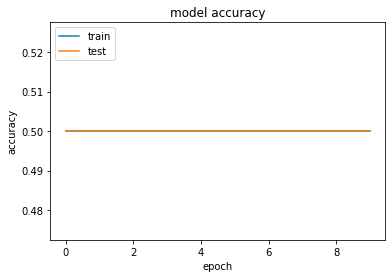

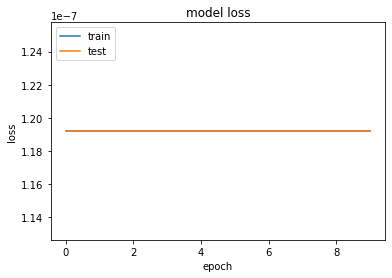

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Softmax

In [ ]:
#Slightly more complex Model frames and duration and frame_count<20,nbframes=20 ,without callbacks
batch_size=64
y=model.predict(valid)
y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[88  0]
 [84  0]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.51      1.00      0.68        88
        norm       0.00      0.00      0.00        84

    accuracy                           0.51       172
   macro avg       0.26      0.50      0.34       172
weighted avg       0.26      0.51      0.35       172

0.5116279069767442


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Number of Frames:40,Kernel 5*5- dense 2 softmax

In [ ]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      # print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<20 or frame_count<40):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

deleted/content/dataset/Crime/Burglary054_x264.mp4
deleted/content/dataset/Crime/Shoplifting036_x264.mp4
deleted/content/dataset/Crime/Robbery087_x264.mp4
deleted/content/dataset/Crime/Shoplifting015_x264.mp4
deleted/content/dataset/Crime/Robbery076_x264.mp4
deleted/content/dataset/Crime/Robbery098_x264.mp4
deleted/content/dataset/Crime/Stealing060_x264.mp4
deleted/content/dataset/Crime/Robbery031_x264.mp4
deleted/content/dataset/Crime/Robbery032_x264.mp4
deleted/content/dataset/Crime/Burglary078_x264.mp4
deleted/content/dataset/Crime/Shoplifting044_x264.mp4
deleted/content/dataset/Crime/Shoplifting003_x264.mp4
deleted/content/dataset/Crime/Robbery044_x264.mp4
deleted/content/dataset/Crime/Robbery039_x264.mp4
deleted/content/dataset/Crime/Stealing069_x264.mp4
deleted/content/dataset/Crime/Robbery012_x264.mp4
deleted/content/dataset/Crime/Shoplifting027_x264.mp4
deleted/content/dataset/Crime/Stealing095_x264.mp4
deleted/content/dataset/Crime/Stealing066_x264.mp4
deleted/content/dataset/

In [ ]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 40
BS = 1# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 88, train count: 181
class norm, validation count: 84, train count: 173
Total data: 2 classes for 354 files for train


In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(128, (11,11), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(128, (11,11), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(96, (7,7), padding='same', activation='relu'))
  model.add(Conv2D(96, (7,7), padding='same', activation='relu'))
  # # model.add(BatchNormalization(momentum=momentum))
  
  # model.add(MaxPool2D())
  
  # model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
  # model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
  model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(GRU(128))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  # model.add(Dense(128, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 172 files for validation
Total data: 2 classes for 0 files for test


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 40, 32)            3186048   
_________________________________________________________________
gru (GRU)                    (None, 128)               62208     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 3,273,154
Trainable params: 3,272,898
Non-trainable params: 256
__________________________________________

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
EPOCHS=1#
#Less complex Model frames and duration<40,nbframes=40,BS=1 ,without callbacks
history=model.fit(
train,
# validation_data=valid,
verbose=1,
epochs=1
)

354/354 [==============================] - 1244s 4s/step - loss: 0.7583 - acc: 0.5000


In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/My Drive/anomalyseg/model<20-40.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/anomalyseg/model<20-40.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/content/drive/My Drive/anomalyseg/model<20-40.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/anomalyseg/model<20-40.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [ ]:
# model.save_weights('/content/drive/My Drive/anomalyseg/mod5fram')
# from keras.models import load_model
# xmodel=keras.models.load_model('/content/drive/My Drive/seg/model<5')
# xmodel.summary()

In [ ]:
loaded_model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)
loaded_model.evaluate(valid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

172

In [ ]:
#NB Frames=20,highly less complex model with many layers commented out,dataset<40 or frame_count<40
batch_size=64
y=model.predict(valid)
y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[88  0]
 [84  0]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.51      1.00      0.68        88
        norm       0.00      0.00      0.00        84

    accuracy                           0.51       172
   macro avg       0.26      0.50      0.34       172
weighted avg       0.26      0.51      0.35       172

0.5116279069767442


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Number of Frames:40,Kernel 5*5- dense 1 sigmoid

In [ ]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      # print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<20 or frame_count<40):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

deleted/content/dataset/Crime/Burglary054_x264.mp4
deleted/content/dataset/Crime/Shoplifting036_x264.mp4
deleted/content/dataset/Crime/Robbery087_x264.mp4
deleted/content/dataset/Crime/Shoplifting015_x264.mp4
deleted/content/dataset/Crime/Robbery076_x264.mp4
deleted/content/dataset/Crime/Robbery098_x264.mp4
deleted/content/dataset/Crime/Stealing060_x264.mp4
deleted/content/dataset/Crime/Robbery031_x264.mp4
deleted/content/dataset/Crime/Robbery032_x264.mp4
deleted/content/dataset/Crime/Burglary078_x264.mp4
deleted/content/dataset/Crime/Shoplifting044_x264.mp4
deleted/content/dataset/Crime/Shoplifting003_x264.mp4
deleted/content/dataset/Crime/Robbery044_x264.mp4
deleted/content/dataset/Crime/Robbery039_x264.mp4
deleted/content/dataset/Crime/Stealing069_x264.mp4
deleted/content/dataset/Crime/Robbery012_x264.mp4
deleted/content/dataset/Crime/Shoplifting027_x264.mp4
deleted/content/dataset/Crime/Stealing095_x264.mp4
deleted/content/dataset/Crime/Stealing066_x264.mp4
deleted/content/dataset/

In [ ]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 40
BS = 1# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 65, train count: 134
class norm, validation count: 50, train count: 103
Total data: 2 classes for 237 files for train


In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(128, (11,11), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(128, (11,11), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(96, (7,7), padding='same', activation='relu'))
  model.add(Conv2D(96, (7,7), padding='same', activation='relu'))
  # # model.add(BatchNormalization(momentum=momentum))
  
  # model.add(MaxPool2D())
  
  # model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
  # model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
  model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(GRU(128))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  # model.add(Dense(128, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 115 files for validation
Total data: 2 classes for 0 files for test


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 40, 32)            3186048   
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               62208     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 3,273,089
Trainable params: 3,272,833
Non-trainable params: 256
__________________________________________

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
EPOCHS=1#
#Less complex Model frames and duration<40,nbframes=40,BS=1 ,without callbacks
history=model.fit(
train,
# validation_data=valid,
verbose=1,
epochs=1
)

237/237 [==============================] - 916s 4s/step - loss: 0.7015 - acc: 0.5000


In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/My Drive/anomalyseg/model<20-40-sigmoid.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/anomalyseg/model<20-40-sigmoid.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/content/drive/My Drive/anomalyseg/model<20-40-sigmoid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/anomalyseg/model<20-40-sigmoid.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [ ]:
# model.save_weights('/content/drive/My Drive/anomalyseg/mod5fram')
# from keras.models import load_model
# xmodel=keras.models.load_model('/content/drive/My Drive/seg/model<5')
# xmodel.summary()

In [ ]:
loaded_model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)
loaded_model.evaluate(valid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

115

In [ ]:
y

array([[0.47261178],
       [0.46839407],
       [0.47261178],
       [0.47261178],
       [0.47261178],
       [0.47261178],
       [0.4850407 ],
       [0.47261178],
       [0.47261178],
       [0.47261178],
       [0.47261178],
       [0.47261178],
       [0.4850428 ],
       [0.4850428 ],
       [0.47261178],
       [0.4945669 ],
       [0.47261178],
       [0.4850428 ],
       [0.50948435],
       [0.47261178],
       [0.4798968 ],
       [0.48500985],
       [0.4798968 ],
       [0.4850407 ],
       [0.49456635],
       [0.47261178],
       [0.4850428 ],
       [0.48503992],
       [0.47261178],
       [0.47261178],
       [0.48511127],
       [0.4885535 ],
       [0.47261178],
       [0.47261178],
       [0.4850428 ],
       [0.4956033 ],
       [0.4818251 ],
       [0.4850428 ],
       [0.4945669 ],
       [0.47261178],
       [0.4798968 ],
       [0.47261178],
       [0.4850428 ],
       [0.47261178],
       [0.48547804],
       [0.47261178],
       [0.47261178],
       [0.505

In [ ]:
#NB Frames=20,highly less complex model with many layers commented out,dataset<40 or frame_count<40
# batch_size=64
# y=model.predict(valid)
y_pred = (y>0.48)*1
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[38 27]
 [24 26]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.61      0.58      0.60        65
        norm       0.49      0.52      0.50        50

    accuracy                           0.56       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.56      0.56      0.56       115

0.5565217391304348


# Number of frames 80 , kernel same as before,sigmoid-1 epoch

In [ ]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<40 or frame_count<80):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

/content/dataset/Crime/Burglary071_x264.mp4 2720
/content/dataset/Crime/Burglary086_x264.mp4 3240
/content/dataset/Crime/Robbery061_x264.mp4 1870
/content/dataset/Crime/Burglary001_x264.mp4 3600
/content/dataset/Crime/Burglary037_x264.mp4 1610
/content/dataset/Crime/Burglary008_x264.mp4 2650
/content/dataset/Crime/Stealing104_x264.mp4 2780
/content/dataset/Crime/Robbery080_x264.mp4 1610
/content/dataset/Crime/Burglary082_x264.mp4 1630
/content/dataset/Crime/Shoplifting040_x264.mp4 1980
/content/dataset/Crime/Robbery007_x264.mp4 1550
/content/dataset/Crime/Burglary032_x264.mp4 14080
/content/dataset/Crime/Stealing050_x264.mp4 2530
/content/dataset/Crime/Burglary055_x264.mp4 2480
/content/dataset/Crime/Stealing022_x264.mp4 1680
/content/dataset/Crime/Robbery010_x264.mp4 1280
/content/dataset/Crime/Burglary095_x264.mp4 22780
/content/dataset/Crime/Burglary040_x264.mp4 4500
/content/dataset/Crime/Robbery025_x264.mp4 1440
/content/dataset/Crime/Stealing078_x264.mp4 1750
/content/dataset/Cri

In [ ]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 80
BS = 1# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 65, train count: 134
class norm, validation count: 50, train count: 103
Total data: 2 classes for 237 files for train


In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(64, (19,19), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(64, (17,17), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(48, (13,13), padding='same', activation='relu'))
  # model.add(Conv2D(48, (12,12), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  # model.add(MaxPool2D())
  
  model.add(Conv2D(64, (8,8), padding='same', activation='relu'))
  # model.add(Conv2D(64, (8,8), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (6,6), padding='same', activation='relu'))
  # model.add(Conv2D(32, (6,6), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(LSTM(64,return_sequences=True))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(LSTM(32)) 
  model.add(Dense(64, activation='relu'))
  # model.add(LSTM(64)) 
  # model.add(Dropout(.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 115 files for validation
Total data: 2 classes for 0 files for test


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 80, 32)            2043280   
_________________________________________________________________
lstm (LSTM)                  (None, 80, 64)            24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,084,753
Trainable params: 2,084,529
Non-trainable params: 224
__________________________________________

In [ ]:
EPOCHS=1#
#More complex Model frames and duration<40,nbframes=20,BS=1 ,without callbacks
history=model.fit(
train,
# validation_data=valid,
verbose=1,
epochs=1
)

237/237 [==============================] - 1124s 5s/step - loss: 0.6933 - acc: 0.5000


In [ ]:
from keras.models import model_from_json
# model_json = model.to_json()
# !mk dir '/content/drive/My Drive/anomalyseg'
# with open("/content/drive/My Drive/anomalyseg/model<40,80-80.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/My Drive/anomalyseg/model<40,80-80.h5")
# print("Saved model to disk")
 
# # later...
 
# load json and create model
json_file = open('/content/drive/My Drive/anomalyseg/model<40,80-80.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/anomalyseg/model<40,80-80.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)
loaded_model.evaluate(valid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

115

In [ ]:
#NB Frames=20,highly less complex model with many layers commented out,dataset<40 or frame_count<40
# batch_size=64
# y=loaded_model.predict(valid)
y_pred = (y>0.5)*1 
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[32 33]
 [33 17]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.49      0.49      0.49        65
        norm       0.34      0.34      0.34        50

    accuracy                           0.43       115
   macro avg       0.42      0.42      0.42       115
weighted avg       0.43      0.43      0.43       115

0.4260869565217391


# Number of frames 80 , More Complex Model,sigmoid-10 epoch

In [49]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<40 or frame_count<80):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

/content/dataset/Crime/Stealing104_x264.mp4 2780
/content/dataset/Crime/Burglary017_x264.mp4 720
deleted/content/dataset/Crime/Burglary017_x264.mp4
/content/dataset/Crime/Shoplifting030_x264.mp4 3321
/content/dataset/Crime/Burglary083_x264.mp4 3630
/content/dataset/Crime/Stealing053_x264.mp4 10290
/content/dataset/Crime/Burglary015_x264.mp4 1050
deleted/content/dataset/Crime/Burglary015_x264.mp4
/content/dataset/Crime/Stealing080_x264.mp4 900
deleted/content/dataset/Crime/Stealing080_x264.mp4
/content/dataset/Crime/Robbery052_x264.mp4 1834
/content/dataset/Crime/Robbery080_x264.mp4 1610
/content/dataset/Crime/Burglary044_x264.mp4 2770
/content/dataset/Crime/Robbery071_x264.mp4 890
deleted/content/dataset/Crime/Robbery071_x264.mp4
/content/dataset/Crime/Stealing011_x264.mp4 3480
/content/dataset/Crime/Burglary022_x264.mp4 2570
/content/dataset/Crime/Stealing054_x264.mp4 1300
/content/dataset/Crime/Robbery069_x264.mp4 660
deleted/content/dataset/Crime/Robbery069_x264.mp4
/content/dataset

In [50]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 80
BS = 1# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 65, train count: 134
class norm, validation count: 50, train count: 103
Total data: 2 classes for 237 files for train


In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(64, (11,11), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(64, (11,11), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(48, (9,9), padding='same', activation='relu'))
  model.add(Conv2D(48, (9,9), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(64, (7,7), padding='same', activation='relu'))
  model.add(Conv2D(64, (7,7), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(LSTM(64,return_sequences=True))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(LSTM(32)) 
  model.add(Dense(64, activation='relu'))
  # model.add(LSTM(64)) 
  # model.add(Dropout(.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)

In [51]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 115 files for validation
Total data: 2 classes for 0 files for test


In [17]:
# model.summary()

In [ ]:
EPOCHS=1#
#More complex Model frames and duration<40,nbframes=20,BS=1 ,without callbacks
history=model.fit(
train,
# validation_data=valid,
verbose=1,
epochs=10
)

Epoch 1/10
237/237 [==============================] - 813s 3s/step - loss: 0.6932 - acc: 0.5000
Epoch 2/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 3/10
237/237 [==============================] - 433s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 4/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 5/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 6/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 7/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 8/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 9/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000
Epoch 10/10
237/237 [==============================] - 434s 2s/step - loss: 0.6931 - acc: 0.5000


In [22]:
from keras.models import model_from_json
# model_json = model.to_json()
# # !mk dir '/content/drive/My Drive/anomalyseg'
# with open("/content/drive/My Drive/anomalyseg/model<40,80-8010ep.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/My Drive/anomalyseg/model<40,80-8010ep.h5")
# print("Saved model to disk")
 
# # later...
 
# load json and create model
json_file = open('/content/drive/My Drive/anomalyseg/model_40,80-8010ep.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/anomalyseg/model_40,80-8010ep.h5")
print("Loaded model from disk")

Loaded model from disk


In [45]:
loaded_model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)
# loaded_model.evaluate(valid)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [53]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

115

## Loaded_model

In [62]:
#NB Frames=80,highly complex model with many layers,dataset<40 or frame_count<80_done using loaded_model
# batch_size=64
# y=loaded_model.predict(valid)
y_pred = (y>0.5)*1 
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[30 35]
 [18 32]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.62      0.46      0.53        65
        norm       0.48      0.64      0.55        50

    accuracy                           0.54       115
   macro avg       0.55      0.55      0.54       115
weighted avg       0.56      0.54      0.54       115

0.5391304347826087


## Done using trained model

In [ ]:
#NB Frames=80,highly complex model with many layers,dataset<40 or frame_count<40
# batch_size=64
# y=loaded_model.predict(valid)
y_pred = (y>0.5)*1 
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[29 36]
 [21 29]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.58      0.45      0.50        65
        norm       0.45      0.58      0.50        50

    accuracy                           0.50       115
   macro avg       0.51      0.51      0.50       115
weighted avg       0.52      0.50      0.50       115

0.5043478260869565


# More

In [ ]:
import cv2
for cls in labels:
  temp=os.listdir("/content/dataset/"+cls)
  for vid in temp:  
    try:
      tempy=os.path.join("/content/dataset",cls,vid)
      cap = cv2.VideoCapture("/content/dataset/"+cls+"/"+vid)
      fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      print(tempy,frame_count)
      # if(fps!=0):
      duration = frame_count/fps
      if(duration<40 or frame_count<40):
        os.remove(tempy)
        print("deleted"+(tempy))
      # else:
      #   os.remove(tempy)
    except:
      os.remove(tempy)
      print("deleted"+(tempy))
    cap.release()

/content/dataset/Crime/Burglary061_x264.mp4 1760
/content/dataset/Crime/Shoplifting041_x264.mp4 2460
/content/dataset/Crime/Stealing080_x264.mp4 900
deleted/content/dataset/Crime/Stealing080_x264.mp4
/content/dataset/Crime/Burglary064_x264.mp4 31780
/content/dataset/Crime/Burglary099_x264.mp4 1320
/content/dataset/Crime/Stealing111_x264.mp4 4560
/content/dataset/Crime/Stealing083_x264.mp4 900
deleted/content/dataset/Crime/Stealing083_x264.mp4
/content/dataset/Crime/Robbery050_x264.mp4 940
deleted/content/dataset/Crime/Robbery050_x264.mp4
/content/dataset/Crime/Burglary063_x264.mp4 2233
/content/dataset/Crime/Stealing101_x264.mp4 1010
deleted/content/dataset/Crime/Stealing101_x264.mp4
/content/dataset/Crime/Stealing096_x264.mp4 3900
/content/dataset/Crime/Burglary039_x264.mp4 6770
/content/dataset/Crime/Robbery038_x264.mp4 1370
/content/dataset/Crime/Burglary084_x264.mp4 4100
/content/dataset/Crime/Robbery056_x264.mp4 2670
/content/dataset/Crime/Robbery066_x264.mp4 4130
/content/dataset

In [ ]:
import os
import glob
import keras
classes=labels
classes.sort()# some global params
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 20
BS = 1# pattern to get videos and classes
glob_pattern='/content/dataset/{classname}/*.mp4'# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
  zoom_range=.1,
  horizontal_flip=True,
  rotation_range=8,
  width_shift_range=.2,
  height_shift_range=.2)# Create video frame generator
train = VideoFrameGenerator(
  classes=classes, 
  glob_pattern=glob_pattern,
  nb_frames=NBFRAME,
  split=.33, 
  shuffle=True,
  batch_size=BS,
  target_shape=SIZE,
  nb_channel=CHANNELS,
  transformation=data_aug,use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Crime, validation count: 65, train count: 134
class norm, validation count: 50, train count: 103
Total data: 2 classes for 237 files for train


In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(320, 240, 3)):
  momentum = .9
  model = keras.Sequential()
  model.add(Conv2D(128, (3,3), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  model.add(MaxPool2D())
  
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  # model.add(BatchNormalization(momentum=momentum))
  
  # flatten...
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LSTM
def action_model(shape=(40, 320, 240, 3), nbout=1):
  # Create our convnet with (320, 240, 3) input shape
  convnet = build_convnet(shape[1:])
  
  # then create our final model
  model = keras.Sequential()    # add the convnet with (5, 112, 112, 3) shape
  model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
  model.add(LSTM(64))    # and finally, we make a decision network
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(128, activation='relu'))
  # model.add(Dropout(.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 320, 240, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
valid = train.get_validation_generator()
test=train.get_test_generator()

Total data: 2 classes for 115 files for validation
Total data: 2 classes for 0 files for test


In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 20, 32)            465408    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 506,881
Trainable params: 506,625
Non-trainable params: 256
_________________________________________________________________


In [ ]:
EPOCHS=5#
#More complex Model frames and duration<40,nbframes=20,BS=1 ,without callbacks
history=model.fit(
train,
validation_data=valid,
verbose=1,
epochs=10
)

237/237 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5000

In [ ]:
from keras.models import model_from_json
# model_json = model.to_json()
# with open("/content/drive/My Drive/anomalyseg/model3.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/My Drive/anomalyseg/model3.h5")
# print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/content/drive/My Drive/anomalyseg/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/anomalyseg/model3.h5")
print("Loaded model from disk")

In [ ]:
# model.save_weights('/content/drive/My Drive/anomalyseg/mod5fram')
# from keras.models import load_model
# xmodel=keras.models.load_model('/content/drive/My Drive/seg/model<5')
# xmodel.summary()

In [ ]:
loaded_model.compile(
    # optimizer,
    "adam",
    'binary_crossentropy',
    metrics=['acc']
)
loaded_model.evaluate(valid)

115/115 [==============================] - 13s 116ms/step - loss: 0.6940 - acc: 0.4348


[0.6940000653266907, 0.43478259444236755]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

In [ ]:
#NB Frames=20,highly less complex model with many layers commented out,dataset<40 or frame_count<40
batch_size=64
y=model.predict(valid)
y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))
print(accuracy_score(temp[:],y_pred))

confusion Matrix
[[ 0 65]
 [ 0 50]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.00      0.00      0.00        65
        norm       0.43      1.00      0.61        50

    accuracy                           0.43       115
   macro avg       0.22      0.50      0.30       115
weighted avg       0.19      0.43      0.26       115

0.43478260869565216


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
EPOCHS=5#
#Less Complex Model 128 96 and all
callbacks = [
keras.callbacks.ReduceLROnPlateau(verbose=1),
keras.callbacks.ModelCheckpoint(
    'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    verbose=1),
]
history=model.fit(
train,
validation_data=valid,
verbose=1,
epochs=EPOCHS,
callbacks=callbacks
)

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 0.6710 - acc: 0.6719
Epoch 00001: saving model to chkp/weights.01-0.66.hdf5
16/16 [==============================] - 193s 12s/step - loss: 0.6710 - acc: 0.6719 - val_loss: 0.6571 - val_acc: 0.6719
Epoch 2/5
16/16 [==============================] - ETA: 0s - loss: 0.6505 - acc: 0.6484
Epoch 00002: saving model to chkp/weights.02-0.64.hdf5
16/16 [==============================] - 9s 552ms/step - loss: 0.6505 - acc: 0.6484 - val_loss: 0.6355 - val_acc: 0.6719
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.6764 - acc: 0.6094
Epoch 00003: saving model to chkp/weights.03-0.66.hdf5
16/16 [==============================] - 9s 552ms/step - loss: 0.6764 - acc: 0.6094 - val_loss: 0.6581 - val_acc: 0.6719
Epoch 4/5
16/16 [==============================] - ETA: 0s - loss: 0.6919 - acc: 0.6562
Epoch 00004: saving model to chkp/weights.04-0.68.hdf5
16/16 [==============================] - 9s 557ms/step - loss: 0.

In [ ]:
EPOCHS=5# create a "chkp" directory before to run that
# Less Complex Model without drop out and reduced units
history=model.fit(
train,
# validation_data=valid,
verbose=1,
epochs=10
# ,callbacks=callbacks
)

Epoch 1/10
16/16 [==============================] - 9s 542ms/step - loss: 0.6783 - acc: 0.6719
Epoch 2/10
16/16 [==============================] - 28s 2s/step - loss: 0.6526 - acc: 0.6797
Epoch 3/10
16/16 [==============================] - 9s 540ms/step - loss: 0.6408 - acc: 0.6719
Epoch 4/10
16/16 [==============================] - 9s 548ms/step - loss: 0.6246 - acc: 0.6953
Epoch 5/10
16/16 [==============================] - 9s 547ms/step - loss: 0.6317 - acc: 0.6875
Epoch 6/10
16/16 [==============================] - 9s 537ms/step - loss: 0.6315 - acc: 0.6875
Epoch 7/10
16/16 [==============================] - 9s 535ms/step - loss: 0.6377 - acc: 0.6719
Epoch 8/10
16/16 [==============================] - 9s 547ms/step - loss: 0.6381 - acc: 0.6875
Epoch 9/10
16/16 [==============================] - 9s 541ms/step - loss: 0.6349 - acc: 0.6797
Epoch 10/10
16/16 [==============================] - 9s 542ms/step - loss: 0.6416 - acc: 0.6641


In [ ]:
#Segmented and removed duration < 1, less complex neural net
history=model.fit(
train,
# validation_data=valid,
verbose=1,
epochs=10
# ,callbacks=callbacks
)

Epoch 1/10
29/29 [==============================] - 557s 19s/step - loss: 0.6941 - acc: 0.5345
Epoch 2/10
29/29 [==============================] - 25s 861ms/step - loss: 0.6883 - acc: 0.5603
Epoch 3/10
29/29 [==============================] - 17s 592ms/step - loss: 0.6836 - acc: 0.5733
Epoch 4/10
29/29 [==============================] - 17s 592ms/step - loss: 0.6869 - acc: 0.5647
Epoch 5/10
29/29 [==============================] - 17s 594ms/step - loss: 0.6864 - acc: 0.5647
Epoch 6/10
29/29 [==============================] - 17s 586ms/step - loss: 0.6870 - acc: 0.5603
Epoch 7/10
29/29 [==============================] - 17s 582ms/step - loss: 0.6856 - acc: 0.5690
Epoch 8/10
29/29 [==============================] - 17s 591ms/step - loss: 0.6858 - acc: 0.5647
Epoch 9/10
29/29 [==============================] - 17s 594ms/step - loss: 0.6871 - acc: 0.5603
Epoch 10/10
29/29 [==============================] - 17s 599ms/step - loss: 0.6877 - acc: 0.5603


In [ ]:
model.evaluate_generator(valid)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.6496166586875916, 0.671875]

In [ ]:
model.evaluate_generator(valid)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.6937780380249023, 0.4285714328289032]

In [ ]:
model.save('/content/drive/My Drive/seg/model3.model')
from keras.models import load_model
xmodel=keras.models.load_model('/content/drive/My Drive/seg/model3.model')
xmodel.summary()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg/model2/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 5, 128)            630720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6

In [ ]:
# # model.save_weights('/content/drive/My Drive/Dataset')
# xmodel = action_model(INSHAPE, len(classes))
# optimizer = keras.optimizers.Adam(0.001)
# xmodel.compile(
#     optimizer,
#     'categorical_crossentropy',
#     metrics=['acc']
# )

In [ ]:
# xmodel.load_weights('/content/drive/My Drive/Dataset')

In [ ]:
temp=list(map(lambda x:x.strip('/content/dataset'),valid.files))
temp=list(map(lambda x:x.split('/')[0],temp))
temp=list(map(lambda x:"no"+x if x=='rm' else x,temp))
temp=list(map(lambda x:labels.index(x),temp))
# len(temp)
len(temp)

298

In [ ]:
# trained on binary classification after removing frames less than 40,80,160(simpler network)
batch_size=64
y=model.predict(valid)
y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:], y_pred, target_names=target_names))

confusion Matrix
[[43  0]
 [21  0]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.67      1.00      0.80        43
        norm       0.00      0.00      0.00        21

    accuracy                           0.67        64
   macro avg       0.34      0.50      0.40        64
weighted avg       0.45      0.67      0.54        64



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(y_pred)

326

In [ ]:
# trained on binary classification after removing frames less than 40(complex network)
y=model.predict(valid)
y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:326], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:326], y_pred, target_names=target_names))

confusion Matrix
[[114   0]
 [212   0]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.35      1.00      0.52       114
        norm       0.00      0.00      0.00       212

    accuracy                           0.35       326
   macro avg       0.17      0.50      0.26       326
weighted avg       0.12      0.35      0.18       326



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# after removinf segments with frames less than 10 , depth = 5
batch_size=64
y=model.predict(valid)
y_pred = np.argmax(y, axis=1)
print("confusion Matrix")
print(confusion_matrix(temp[:-3], y_pred))
print('Classification Report')
target_names = labels
print(classification_report(temp[:-3], y_pred, target_names=target_names))

confusion Matrix
[[ 0 65]
 [ 0 47]]
Classification Report
              precision    recall  f1-score   support

       Crime       0.00      0.00      0.00        65
        norm       0.42      1.00      0.59        47

    accuracy                           0.42       112
   macro avg       0.21      0.50      0.30       112
weighted avg       0.18      0.42      0.25       112



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
history.history

{'acc': [0.26724138855934143,
  0.3017241358757019,
  0.24568966031074524,
  0.2844827473163605,
  0.3017241358757019],
 'loss': [1.423452615737915,
  1.4363266229629517,
  1.4211052656173706,
  1.400246024131775,
  1.385802149772644],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001],
 'val_acc': [0.3125,
  0.2946428656578064,
  0.2946428656578064,
  0.3303571343421936,
  0.2767857015132904],
 'val_loss': [1.336680293083191,
  1.3574830293655396,
  1.3498440980911255,
  1.35509192943573,
  1.3534997701644897]}

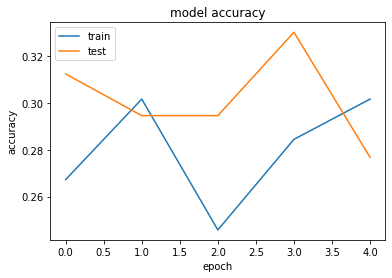

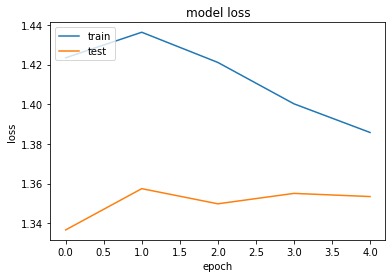

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()